In [ ]:
!pip install anytree

Node: K, Count: 5, Parent: root
Node: E, Count: 4, Parent: K
Node: O, Count: 3, Parent: E
Node: Y, Count: 2, Parent: O
Node: M, Count: 1, Parent: Y
Node: M, Count: 1, Parent: E
Node: Y, Count: 1, Parent: K
Node: M, Count: 1, Parent: Y


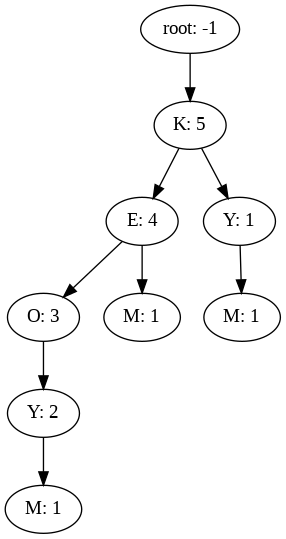

{'K'}
{'E'}
{'O'}
{'Y'}
{'M'}
{'E', 'K'}
{'K', 'O'}
{'Y', 'K'}
{'M', 'K'}
{'E', 'O'}
{'Y', 'E'}
{'M', 'E'}
{'Y', 'O'}
{'Y', 'M'}
{'E', 'K', 'O'}
{'Y', 'E', 'K'}
{'M', 'E', 'K'}
{'Y', 'K', 'O'}
{'Y', 'M', 'K'}
{'Y', 'E', 'O'}
{'Y', 'M', 'E'}
{'Y', 'E', 'K', 'O'}
{'Y', 'M', 'E', 'K'}
Rule: {'K'} -> {'E'} | Confidence: 0.80 | Lift: 1.20
Rule: {'E'} -> {'K'} | Confidence: 1.25 | Lift: 1.50
Rule: {'O'} -> {'K'} | Confidence: 1.67 | Lift: 2.00
Rule: {'Y'} -> {'K'} | Confidence: 1.67 | Lift: 2.00
Rule: {'M'} -> {'K'} | Confidence: 1.67 | Lift: 2.00
Rule: {'O'} -> {'E'} | Confidence: 1.33 | Lift: 2.00
Rule: {'E'} -> {'O'} | Confidence: 0.75 | Lift: 1.50
Rule: {'E'} -> {'Y'} | Confidence: 0.75 | Lift: 1.50
Rule: {'Y'} -> {'E'} | Confidence: 1.33 | Lift: 2.00
Rule: {'E'} -> {'M'} | Confidence: 0.75 | Lift: 1.50
Rule: {'M'} -> {'E'} | Confidence: 1.33 | Lift: 2.00
Rule: {'O'} -> {'Y'} | Confidence: 1.00 | Lift: 2.00
Rule: {'Y'} -> {'O'} | Confidence: 1.00 | Lift: 2.00
Rule: {'M'} -> {'Y'} | Confi

In [ ]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
from anytree import NodeMixin
from graphviz import Digraph
from IPython.display import display, Image


file_path = "/content/Horizontal_Format.xlsx"
min_support = 3
min_confidence = 0.7


def load_transactions(file_path):
    data = pd.read_excel(file_path, header=None)
    return [str(x[1]).split(",") for x in data.values]


def preprocess_transactions(transactions, min_support):
    item_support = calculate_item_support(transactions)
    frequent_items = {item for item, count in item_support.items() if count >= min_support}
    sorted_items = sorted(frequent_items, key=lambda x: -item_support[x])

    sorted_transactions = [
        [item for item in sorted_items if item in transaction] for transaction in transactions
    ]
    return sorted_transactions, sorted_items, item_support

def calculate_item_support(transactions):
    item_support = defaultdict(int)
    for transaction in transactions:
        for item in set(transaction):
            item_support[item] += 1
    return item_support


class FpNode(NodeMixin):
    def __init__(self, name, parent=None, count=1):
        self.name = name
        self.count = count - 1
        self.parent = parent
        self.link = None

class FpTree:
    def __init__(self):
        self.nodes = {}
        self.last_link = {}

    def build(self, parent, items):
        if not items:
            return
        item = items[0]
        if (parent, item) not in self.nodes:
            self.nodes[(parent, item)] = FpNode(item, parent)
            if item in self.last_link:
                self.last_link[item].link = self.nodes[(parent, item)]
            self.last_link[item] = self.nodes[(parent, item)]
        self.nodes[(parent, item)].count += 1  # Increment during build
        self.build(self.nodes[(parent, item)], items[1:])

    def print_tree(self):
        for (parent, item), node in self.nodes.items():
            print(f"Node: {item}, Count: {node.count}, Parent: {node.parent.name if node.parent else None}")


def visualize_tree(fp_tree, root_node):
    dot = Digraph()
    add_nodes(dot, root_node)
    display(Image(dot.pipe(format="png")))

def add_nodes(dot, node):
    dot.node(str(id(node)), f"{node.name}: {node.count}")
    for child in node.children:
        dot.edge(str(id(node)), str(id(child)))
        add_nodes(dot, child)


def generate_frequent_itemsets(transactions, min_support, sorted_items):
    frequent_itemsets = []
    current_itemsets = [[item] for item in sorted_items]
    while current_itemsets:
        next_itemsets = []
        itemset_support = calculate_itemset_support(current_itemsets, transactions)
        for itemset, count in itemset_support.items():
            if count >= min_support:
                frequent_itemsets.append(set(itemset))
                next_itemsets.append(itemset)
        current_itemsets = generate_next_itemsets(next_itemsets)
    return frequent_itemsets

def calculate_itemset_support(itemsets, transactions):
    itemset_support = defaultdict(int)
    for itemset in itemsets:
        for transaction in transactions:
            if set(itemset).issubset(transaction):
                itemset_support[tuple(itemset)] += 1
    return itemset_support

def calculate_support(itemset, transactions):
    return sum(1 for transaction in transactions if itemset.issubset(transaction))

def generate_next_itemsets(itemsets):
    return [
        list(set(i).union(set(j))) for i in itemsets for j in itemsets if len(set(i).union(set(j))) == len(i) + 1
    ]


def generate_rules(frequent_itemsets, transactions, min_confidence):
    num_transactions = len(transactions)
    rules = []
    for itemset in frequent_itemsets:
        rules.extend(generate_rules_for_itemset(itemset, transactions, min_confidence, num_transactions))
    return rules

def generate_rules_for_itemset(itemset, transactions, min_confidence, num_transactions):
    rules = []
    if len(itemset) < 2:
        return rules
    for x in range(1, len(itemset)):
        for y in combinations(itemset, x):
            z = set(itemset) - set(y)
            z_support = calculate_support(z, transactions)
            sh_support = calculate_support(set(y), transactions)

            if z_support > 0:
                confidence = sh_support / z_support
                if confidence >= min_confidence:
                    lift = confidence / (sh_support / num_transactions)
                    rules.append((z, set(y), confidence, lift))
    return rules


transactions = load_transactions(file_path)
sorted_transactions, sorted_items, item_support = preprocess_transactions(transactions, min_support)


fp_tree = FpTree()
root = FpNode("root", count=0)
for transaction in sorted_transactions:
    fp_tree.build(root, transaction)


fp_tree.print_tree()
visualize_tree(fp_tree, root)


frequent_itemsets = generate_frequent_itemsets(sorted_transactions, min_support, sorted_items)

for i, itemset in enumerate(frequent_itemsets, 1):
    print(itemset)

rules = generate_rules(frequent_itemsets, sorted_transactions, min_confidence)
for rule in rules:
    antecedent, consequent, confidence, lift = rule
    print(f"Rule: {set(antecedent)} -> {set(consequent)} | Confidence: {confidence:.2f} | Lift: {lift:.2f}")
